In [1]:
import os, glob, re, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

from keras import utils
from sklearn.preprocessing import LabelEncoder

In [2]:
# dir_path points towards where to find the image dataset
dir_path = "brain_tumor_dataset"
IMAGE_SHAPE = (224, 224)

random_sample = 1

# IMPORTANT - Check these are correct

MIXUP = True # Whether to train the model with mixup
ITERS = 30 # How many mixup images to create per image
BETA = True # Whether to sample from the beta function
BALANCE = True # Whether to balance the data and over-sample certain classes
AUG = True # whether to augment the data


In [3]:
# Read the folders folders
directories = os.listdir(dir_path)

files = [] 
labels = []

# Read files for each directory
for folder in directories:
    
    fileList = glob.glob(f'{dir_path}/{folder}/*')
    labels.extend([folder for _ in fileList])
    files.extend(fileList)

len(files), len(labels)

(253, 253)

In [4]:
# Count the number of labels to get an idea of how balanced the dataset is
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{'no': 98, 'yes': 155}


In [5]:
# One hot encoding

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = utils.to_categorical(encoded_Y,dtype ="uint8", num_classes = 2)

labels = np.array(dummy_y)

print(f"Classes are {encoder.classes_}")

Classes are ['no' 'yes']


In [6]:
# The data augmentation to do. This applies a random horizontal flip and a random tilt.
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation((-0.05, 0.05)),
])

# create prepare_image method
# used to preprocess the image for efficientNet model

def prepare_image(file1: str, label1: str, file2: str = None, label2: str = None, beta = False, augment = True):
    """Prepares the image for the model

    Args:
        file1 (str): The path of  the first image
        label1 (str): The label of the first image
        file2 (str, optional): The path of  the second image. If not none, applies mixup. Defaults to None.
        label2 (str, optional): The label of the second image. Defaults to None.
        beta (bool, optional): If true, sample from teh beta function for mixup. Defaults to False.
        augment (bool, optional): If true, apply augmentations. Defaults to True.

    Returns:
        image, label
    """

    # Load the first image, apply augmentations
    img1 = image.load_img(file1, target_size=IMAGE_SHAPE)
    if augment:
        img1 = data_augmentation(img1)
    img_array = image.img_to_array(img1)
    label = label1

    if file2:

        # Load second image, apply augmentations
        img2 = image.load_img(file2, target_size=IMAGE_SHAPE)
        if augment:
            img2 = data_augmentation(img2)
        img_array2 = image.img_to_array(img2)

        # Generate alpha value for MixUp
        alpa = 0
        if beta:
            alpha = np.random.beta(0.2, 0.2, 1)
        else:
            alpha = random.random()

        # Combine the 2 images 
        img_array = (alpha * img_array) + ((1-alpha) * img_array2)
        label     = (alpha * label1) +    ((1-alpha) * label2)

    return tf.keras.applications.efficientnet.preprocess_input (img_array), label

Label is [0.35630345 0.64369655]


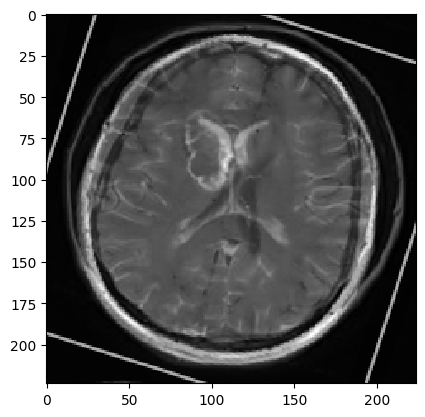

In [7]:
#TEST MIXUP

test_image, label = prepare_image(files[70], labels[70],  files[101], labels[100], False)
test_image = tf.keras.utils.array_to_img(test_image)

print(f"Label is {label}")

plt.imshow(test_image, interpolation='nearest')

In [8]:
# Split the data into testing, training and validation data

x_train, x_tv, y_train, y_tv = train_test_split(files, labels, test_size=.5, random_state = random_sample) # Normally .3
x_test, x_val, y_test, y_val = train_test_split(x_tv, y_tv, test_size=.4, random_state = random_sample) # Normally .5

In [9]:
# The dictionary holds list of images and for each one has its target/label
images = {
    'image_train': [], 
    'target_train': [],
    'image_test': [], 
    'target_test': [],
    'image_val': [],
    'target_val': []
}

print('Preparing the images...')

def get_balance_iters(label):
    # Returns a value for over-sampling if balancing the data
    if label[0] == "no":
        return 1
    else:
        return 2

print("Preparing training data")
for file, label in zip(x_train, y_train):
    # Only go through training data, testing data should not be used for mixup

    # If balancing the data, use the label to find out how many times to iterate through the image
    if BALANCE == True:
        balance_iters = get_balance_iters(label)
    else:
        balance_iters = 1

    for value in range(balance_iters):

        if MIXUP == False:
             # Prepare image without mixup
            new_file, new_label = prepare_image(file, label, beta = BETA, augment = AUG)
            images['image_train'].append(new_file)
            images['target_train'].append(new_label)

        elif MIXUP == True:
            # Prepare image with mixup
            # Iterate through the number of ITERS
            for i in range(ITERS):
                diff_label = False
                while diff_label == False:
                    # Select a random file index
                    random_file_i = random.randint(0,len(files)-1)
                    # Mixup the two images
                    new_file, new_label = prepare_image(file, label, files[random_file_i],labels[random_file_i], beta = BETA, augment = AUG)
                    
                    if new_label[0] != label[0]:
                        diff_label = True

                images['image_train'].append(new_file)
                images['target_train'].append(new_label)

print("Preparing testing data")
for file, label in zip(x_test, y_test):

    # If balancing the data, use the label to find out how many times to iterate through the image
    if BALANCE == True:
        balance_iters = get_balance_iters(label)
    else:
        balance_iters = 1

    for value in range(balance_iters):
        # Prepare the image
        new_file, new_label = prepare_image(file, label, beta = BETA, augment = AUG)
        images['image_test'].append(new_file)
        images['target_test'].append(new_label)

print("Preparing validation data")
for file, label in zip(x_val, y_val):

    # If balancing the data, use the label to find out how many times to iterate through the image
    if BALANCE == True:
        balance_iters = get_balance_iters(label)
    else:
        balance_iters = 1

    for value in range(balance_iters):
        # Prepare the image
        new_file, new_label = prepare_image(file, label, beta = BETA, augment = AUG)
        images['image_val'].append(new_file)
        images['target_val'].append(new_label)

print('Finished.')

Preparing the images...
Preparing training data
Preparing testing data
Preparing validation data
Finished.


In [10]:
class_counts = [sum(col) for col in zip(*images['target_train'])]
print(f"no: {class_counts[0]}  yes: {class_counts[1]}")

no: 3837.698107294233  yes: 3722.3018927057633


In [11]:
# convert lists to arrays 
x_train = np.array(images['image_train'])
y_train = np.array(images['target_train'])
x_test  = np.array(images['image_test'])
y_test  = np.array(images['target_test'])
x_val   = np.array(images['image_val'])
y_val   = np.array(images['target_val'])


In [12]:
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

((7560, 224, 224, 3),
 (152, 224, 224, 3),
 (102, 224, 224, 3),
 (7560, 2),
 (152, 2),
 (102, 2))

In [13]:
# The code is creating a ResNet152V2 model with pre-trained weights from the ImageNet dataset. 
# The base model is frozen, meaning its weights will not be updated during training. 
# The code then appends additional layers on top of the base model for transfer learning.

from tensorflow.keras.applications import resnet_v2
base_model = resnet_v2.ResNet152V2(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMAGE_SHAPE, 3),
    classes=3)

# Freeze the base_model
base_model.trainable = False

# append my own layers on the top of the model for Transfer Learning
x = base_model.output

# 1st conv block
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 2nd conv block
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 1st FC layer
x = layers.Flatten()(x) 
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# 2nd FC layer
x = layers.Dense(32, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Dense(2, 'softmax')(x)

incept_model = keras.models.Model(inputs = base_model.input, outputs = x)

# compile the model
incept_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.categorical_crossentropy, metrics= [metrics.CategoricalAccuracy()])

# incept_model.summary()

In [14]:
EPOCHS = 40
# Trains and returns incept_model. fit ( x_train y_train )
earlyStop = keras.callbacks.EarlyStopping(patience=60) 
best_model = keras.callbacks.ModelCheckpoint(filepath='lots_of_test_data.h5', save_best_only=True) 

with tf.device('/gpu:0'):
    history = incept_model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=[earlyStop, best_model]) 

Epoch 1/40
237/237 [==============================] - ETA: 0s - loss: 0.5950 - categorical_accuracy: 0.7136

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


237/237 [==============================] - 522s 2s/step - loss: 0.5950 - categorical_accuracy: 0.7136 - val_loss: 0.5265 - val_categorical_accuracy: 0.7451
Epoch 2/40
237/237 [==============================] - 520s 2s/step - loss: 0.4965 - categorical_accuracy: 0.8049 - val_loss: 2.3788 - val_categorical_accuracy: 0.3529
Epoch 3/40
237/237 [==============================] - 523s 2s/step - loss: 0.4554 - categorical_accuracy: 0.8357 - val_loss: 2.0578 - val_categorical_accuracy: 0.6471
Epoch 4/40
237/237 [==============================] - 522s 2s/step - loss: 0.4247 - categorical_accuracy: 0.8544 - val_loss: 3.6872 - val_categorical_accuracy: 0.3922
Epoch 5/40
237/237 [==============================] - 536s 2s/step - loss: 0.3970 - categorical_accuracy: 0.8815 - val_loss: 0.3103 - val_categorical_accuracy: 0.8431
Epoch 6/40
237/237 [==============================] - 531s 2s/step - loss: 0.3779 - categorical_accuracy: 0.8866 - val_loss: 2.0632 - val_categorical_accuracy: 0.6471
Epoch 7/4

KeyboardInterrupt: 

In [15]:
hist = history.history

plt.plot(hist['loss'], label=  'loss')
plt.plot(hist['val_loss'], label = 'val_loss')
plt.plot(hist['categorical_accuracy'], label='accuracy')
plt.plot(hist['val_categorical_accuracy'], label='val_accuracy')
plt.legend()

NameError: name 'history' is not defined

In [16]:
# Load the model with the best validation score
incept_model = keras.models.load_model("lots_of_test_data.h5")

incept_model.evaluate(x=x_test, y = y_test, batch_size=32, verbose=1)

5/5 [==============================] - 12s 2s/step - loss: 0.4039 - categorical_accuracy: 0.7829


[0.40387800335884094, 0.7828947305679321]

In [17]:
# open train the last 100 layers
for layer in incept_model.layers[720:]:
    layer.trainable = True
    
# compile the model with new optimizer and lr=.0001
incept_model.compile(optimizer=optimizers.RMSprop(.0001), loss = losses.categorical_crossentropy, metrics=[metrics.CategoricalAccuracy()])

# incept_model.summary()

In [18]:
earlyStop = keras.callbacks.EarlyStopping(patience=60) 
best_model = keras.callbacks.ModelCheckpoint(filepath='lots_of_test_data_2.h5', save_best_only=True) 

# load the best weights
# incept_model.set_weights(best_weights)

with tf.device('/gpu:0'):
    history = incept_model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=[earlyStop, best_model]) 

Epoch 1/40
237/237 [==============================] - 524s 2s/step - loss: 0.3077 - categorical_accuracy: 0.9347 - val_loss: 0.2253 - val_categorical_accuracy: 0.8922
Epoch 2/40
237/237 [==============================] - 521s 2s/step - loss: 0.3037 - categorical_accuracy: 0.9410 - val_loss: 0.0997 - val_categorical_accuracy: 0.9706
Epoch 3/40
237/237 [==============================] - 525s 2s/step - loss: 0.3000 - categorical_accuracy: 0.9402 - val_loss: 0.1563 - val_categorical_accuracy: 0.9510
Epoch 4/40
237/237 [==============================] - 567s 2s/step - loss: 0.2968 - categorical_accuracy: 0.9410 - val_loss: 0.3419 - val_categorical_accuracy: 0.8039
Epoch 5/40
237/237 [==============================] - 544s 2s/step - loss: 0.2977 - categorical_accuracy: 0.9414 - val_loss: 1.6257 - val_categorical_accuracy: 0.5980
Epoch 6/40
237/237 [==============================] - 544s 2s/step - loss: 0.2973 - categorical_accuracy: 0.9443 - val_loss: 0.2813 - val_categorical_accuracy: 0.872

KeyboardInterrupt: 

In [19]:
best_model = keras.models.load_model("lots_of_test_data_2.h5")

x = best_model.evaluate(x=x_test, y = y_test, batch_size=32, verbose=1)

5/5 [==============================] - 12s 2s/step - loss: 0.0813 - categorical_accuracy: 0.9868
